In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import geopandas as gpd
import sampers
import mscthesis
import plotly.graph_objects as pgo
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import pairwise_distances
import time

# Sampers

In [3]:
sampers_scale = "east"

In [4]:
# Zones
sampers_zones = sampers.read_shp(sampers.shps[sampers_scale])

# ODM
sampers_odm = sampers.read_odm(sampers.odms[sampers_scale]).set_index(['ozone', 'dzone'])['total']

# Drop unknown zones (ie. trips between zones that are not part of shapefile)
# If ODM does not contain trips between regions they are set to 0.0
sampers_odm = sampers_odm.reindex(
    pd.MultiIndex.from_product([
        sampers_zones['zone'],
        sampers_zones['zone'],
    ]),
    fill_value=0.0,
)

# Normalize
sampers_odm = sampers_odm / sampers_odm.sum()

print("Sampers zones\t", sampers_zones.shape)
print("Sampers ODM\t", sampers_odm.shape)

Sampers zones	 (3038, 5)
Sampers ODM	 (9229444,)


In [5]:
# Distances between regions
sampers_zonesx = sampers_zones.set_index('zone')
distances = pairwise_distances(
    list(zip(
        sampers_zonesx.geometry.centroid.x.to_list(),
        sampers_zonesx.geometry.centroid.y.to_list(),
    ))
)
distancesx = pd.DataFrame(
    distances / 1000,
    columns=sampers_zonesx.index,
    index=sampers_zonesx.index,
).stack().reindex(sampers_odm.index)

print("Sampers distances\t", distancesx.shape)

Sampers distances	 (9229444,)


# Visits

In [69]:
visits = pd.read_csv('./../../dbs/sweden/visits-song-infered.csv').set_index('userid')
visits = gpd.GeoDataFrame(
    visits,
    crs="EPSG:4326",
    geometry=gpd.points_from_xy(visits.longitude, visits.latitude),
)
visits = visits.to_crs(sampers_zones.crs)
print("Visits\t", visits.shape)

Visits	 (2027200, 7)


In [70]:
# Remove consecutive region visits
visits = mscthesis.remove_consecutive_region_visits(visits)

# TODO: Only use users from corresponding region

In [71]:
# Align regions to Sampers zones
regional_visits = visits[visits.kind == 'region']
print("Regional visits before align\t", regional_visits.shape)
user_regions = regional_visits.groupby(['userid', 'region']).head(1)
print("User regions before align\t", user_regions.shape)
user_zones = gpd.sjoin(user_regions, sampers_zones, op='intersects')[['region', 'zone']]
print("User zones after align\t\t", user_zones.shape)
regional_visitsx = user_zones.merge(regional_visits, on=['userid', 'region'])
print("Regional visits after align\t", regional_visitsx.shape)
print()
print("Regional visits lost during align\t", regional_visits.shape[0] - regional_visitsx.shape[0])

Regional visits before align	 (1919531, 7)
User regions before align	 (185754, 7)
User zones after align		 (148967, 2)
Regional visits after align	 (1771168, 8)

Regional visits lost during align	 148363


In [72]:
# Align points to Sampers zones
point_visits = visits[visits.kind == 'point']
print("Point visits before align\t", point_visits.shape)
point_visitsx = gpd.sjoin(point_visits, sampers_zones, op='intersects')
print("Point visits after align\t", point_visitsx.shape)
print()
print("Point visits lost during align\t", point_visits.shape[0] - point_visitsx.shape[0])

Point visits before align	 (107574, 7)
Point visits after align	 (93750, 12)

Point visits lost during align	 13824


In [73]:
# Recombine
visitsx = pd.concat([
    regional_visitsx[['day', 'timeslot', 'zone']],
    point_visitsx[['day', 'timeslot', 'zone']]
])
# Reorder based on index (userid, day, timeslot) to get visits in chonological order
visitsx = visitsx.reset_index().set_index(['userid', 'day', 'timeslot']).sort_index().reset_index().set_index('userid')
print("Visits after align\t", visitsx.shape)

Visits after align	 (1864918, 3)


In [74]:
# Create ODM from visits
twitter_trips = mscthesis.visit_gaps(visitsx[['zone']])
twitter_odm = twitter_trips.groupby(['zone_origin', 'zone_destination']).size()
print("Twitter ODM before reindex\t", twitter_odm.shape)

# Reindex to Sampers ODM
twitter_odm = twitter_odm.reindex(sampers_odm.index, fill_value=0)
print("Twitter ODM after reindex\t", twitter_odm.shape)

# Normalize
twitter_odm = twitter_odm / twitter_odm.sum()

Twitter ODM before reindex	 (184720,)
Twitter ODM after reindex	 (9229444,)


# TODO: Distance filter for national scale

# Visual comparison

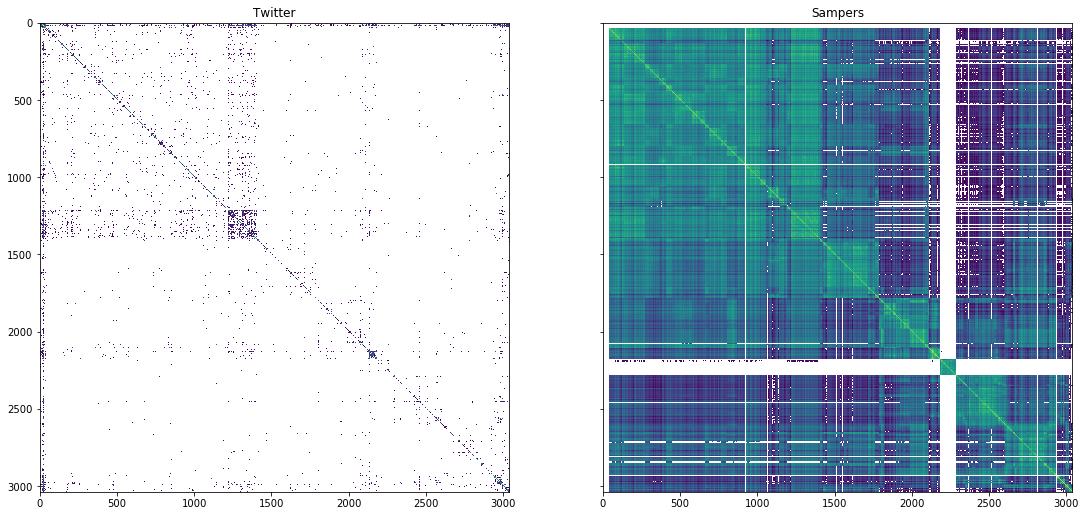

In [75]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(18.5, 10.5)
ax1.imshow(twitter_odm.unstack().values, norm = mpl.colors.LogNorm())
ax2.imshow(sampers_odm.unstack().values, norm = mpl.colors.LogNorm())
ax1.set_title('Twitter')
ax2.set_title('Sampers')
plt.show()

In [76]:
score = mscthesis.spssim(sampers_odm, twitter_odm, distancesx, nquantiles=100)

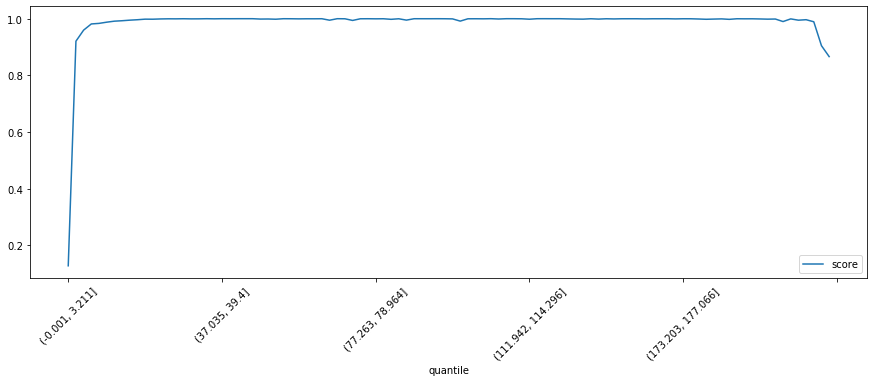

In [77]:
score.plot(figsize=(15,5), rot=45)

In [78]:
score.describe()

,score
count,100.000000
mean,0.986025
std,0.088630
min,0.127752
25%,0.998150
50%,0.999483
75%,0.999760
max,0.999968


In [79]:
score

,score
quantile,
"(-0.001, 3.211]",0.127752
"(3.211, 5.192]",0.920523
"(5.192, 6.939]",0.959603
"(6.939, 8.647]",0.981428
"(8.647, 10.313]",0.983384
...,...
"(277.455, 291.861]",0.994691
"(291.861, 312.377]",0.996412
"(312.377, 348.792]",0.989120
